# Hydrodynamical Simulations

Now we have ICs with baryons we need to compile a new version of SWIFT with the hydrodynamics turned on (NOTE: you can run a DMO simulation like before with a version of SWIFT configured for hydrodynamics but the reverse is not true). 

To do this we will need to reconfigure SWIFT with some extra configuration flags:
```
./configure --disable-mpi --disable-compiler-warnings --disable-doxygen-doc --disable-hand-vec --with-hydro=sphenix --with-kernel=wendland-C2
```
(here I've again included the Mac caveat options but you may not need to). There are a fair few different hydrodynamics schemes and kernels in SWIFT, here we are using the default choice of SPHENIX ([Borrow+22](https://ui.adsabs.harvard.edu/abs/2022MNRAS.511.2367B/abstract)) combined with the $C2$ Wendlend kernel.

Now invoke `make` again and you'll have a new `swift` executable capable of handling hydrodynamics.

# The Parameter File

We now need to use the example parameter file `params/hydro_merger.yml`. This file contains a new `SPH` block with all the parameters controlling hydrodynamical calculations take a look but you do not need to modify these (or should not need to). We will again have to modify the softenings for our set-up though. Since we changed the mass of the dark matter particles their softening will also have changed. Let's recalculate the softenings and add them to the parameter file.

You've got here now so I can point out that you can get SWIFT to generate gas much more robustly than we did by invoking `Initial_Conditions:generate_gas_in_ics: 1` in the parameter file if you are running with cosmology turned on, (we will do this next). Had we used that I wouldn't have had an excuse to get you to muck around making baryons...

In [2]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

# Enter the values you choose from the initial conditions notebook
npart1 = 10000
npart2 = 5000
nbkg = 25 ** 3
boxsize = 2

def soft(boxsize, npart1, npart2, nbkg, cbf=0.1675):
    part_mass = (cosmo.Om(0) * cosmo.critical_density(0) * boxsize ** 3 / (npart1 + npart2 + nbkg)).to(u.Msun)
    gas_mass = part_mass * cbf
    dm_mass = part_mass - gas_mass
    dm_xbar = (1 / ((cosmo.Om(0) - cosmo.Ob(0)) * cosmo.critical_density(0) / dm_mass)) ** (1/3)
    gas_xbar = (1 / (cosmo.Ob(0) * cosmo.critical_density(0) / gas_mass)) ** (1/3)

    return 0.04 * dm_xbar.to(u.Mpc).value, 0.04 * gas_xbar.to(u.Mpc).value


# Compute the softening lengths
comoving_dm_softening, comoving_baryon_softening = soft(boxsize * u.Mpc, npart1, npart2, nbkg)
print("comoving_DM_softening =", comoving_dm_softening)
print("max_physical_DM_softening =", comoving_dm_softening / (1 + 2.7))
print("comoving_baryon_softening =", comoving_baryon_softening)
print("max_physical_baryon_softening =", comoving_baryon_softening / (1 + 2.7))

comoving_DM_softening = 0.002547492697307887
max_physical_DM_softening = 0.0006885115398129423
comoving_baryon_softening = 0.002606480979964501
max_physical_baryon_softening = 0.0007044543189093246


# Running The Simulation

Once again, before we run the simulation **navigate on the terminal to the base of the SWIFT-Workshop directory**, all of the parameter file paths assume you are running SWIFT at this location.

To run the hydrodynamical simulation we now just need to add the `--hydro` flag to the command we used previously for the DMO run to turn on hydrodynamics in addition to gravity, and point to the hydro parameter file.
```
/path/to/SWIFT/swift --self-gravity --hydro --threads <n> params/hydro_merger.yml
```

Agina, if you want a more verbose output to see what SWIFT reports while it's running hydrodynamics you can add `-v 1` to enable verbose outputs. If you wish you could instead remove `--self-gravity` to run a purely hydrodynamical simulation and see what it would look like.

## Visulising the Simulation

Once the simulation finishes let's look at what the simulation looks like again. Below is a modified version of the code we used for the DMO simulation which visualises the merger but this time we have a left-hand panel showing the dark matter density and a right-hand panel which shows the gas density. You will once again find the resultant movie in the `videos` directory.

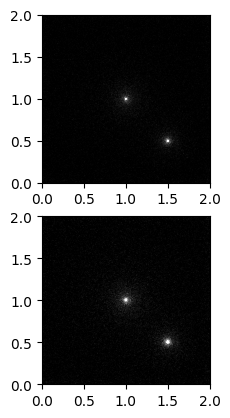

In [3]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

# How many frames will there be? Change this if necessary
nframes = 501

# Set up the plot
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Open the first snapshot and extract the DM coordinates
hdf = h5py.File("../snapshots/hydro_merger/snapshot_0000.hdf5", "r")
dm_pos = hdf["PartType1/Coordinates"][:]
gas_pos = hdf["PartType0/Coordinates"][:]
hdf.close()

# Make the first frame from the first snapshot at softening resolution for dm and gas
dm_H, _, _ = np.histogram2d(dm_pos[:, 0], dm_pos[:, 1], bins=np.arange(0, boxsize + comoving_dm_softening, comoving_dm_softening))
gas_H, _, _ = np.histogram2d(gas_pos[:, 0], gas_pos[:, 1], bins=np.arange(0, boxsize + comoving_baryon_softening, comoving_baryon_softening))

# Plot the first frame
im1 = ax1.imshow(np.arcsinh(dm_H), cmap="Greys_r", extent=[0, boxsize, 0, boxsize])
im2 = ax2.imshow(np.arcsinh(gas_H), cmap="Greys_r", extent=[0, boxsize, 0, boxsize])

def animate(i):
    """
    Make each frame for snapshot i.
    """

    # Open the snapshot and extract DM coordinates
    hdf = h5py.File("../snapshots/hydro_merger/snapshot_%s.hdf5" % str(i).zfill(4), "r")
    dm_pos = hdf["PartType1/Coordinates"][:]
    gas_pos = hdf["PartType0/Coordinates"][:]
    hdf.close()

    # Make a 2D histogram at softening resolution
    dm_H, _, _ = np.histogram2d(dm_pos[:, 0], dm_pos[:, 1], bins=np.arange(0, boxsize + comoving_dm_softening, comoving_dm_softening))
    gas_H, _, _ = np.histogram2d(gas_pos[:, 0], gas_pos[:, 1], bins=np.arange(0, boxsize + comoving_baryon_softening, comoving_baryon_softening))

    # Populate the frame with this 2D histogram
    im1.set_array(dm_H)
    im2.set_array(gas_H)

    return [im1, im2]

# Make the animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=nframes)

# Write it to mp4
FFwriter = matplotlib.animation.FFMpegWriter(fps=10)
ani.save('../videos/Hydro_merger.mp4', writer =FFwriter)